<a href="https://colab.research.google.com/github/abhiraman/Capstone_Project/blob/main/Clubbed_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Syncing With GitHub


In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
# Clone the entire repo.
!git clone https://github.com/abhiraman/Capstone_Project.git


fatal: could not create work tree dir 'Capstone_Project': Operation not supported


In [3]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=4182ceea61ca926a32613b4d1c811644dafa6f16ebce14ad97072b0f43855d5c
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [4]:
import os
import string
import random
from google.colab.patches import cv2_imshow
import cv2
import json
from pprint import pprint
import PIL as pl
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [5]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg


     |████████████████████████████████| 276kB 13.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=da157f2c419b68978b04222fe047c1e61945164ac6b2fc583baa12827b99660e
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 800kB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |███████████████

In [6]:
from detectron2.utils.visualizer import Visualizer

In [7]:
%cd /gdrive/My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition
!ls

/gdrive/My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition
Annotation  Images     Obj_config.yml  readme.txt
clone-repo  input.jpg  output	       train_crop_annot.txt


In [8]:
cfg = get_cfg()
cfg.merge_from_file("Obj_config.yml")
predictor = DefaultPredictor(cfg)

In [9]:
%cd /gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images
!ls

/gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images
1514.jpg  3067.jpg  3548.jpg  3574.jpg	4350.jpg


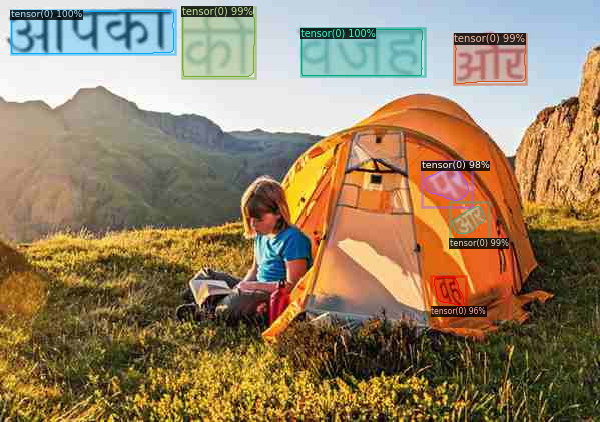

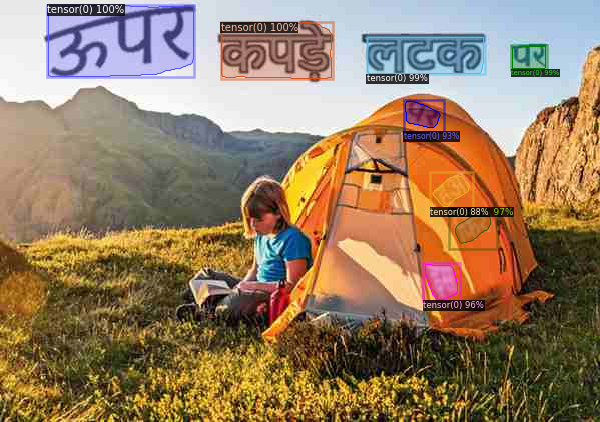

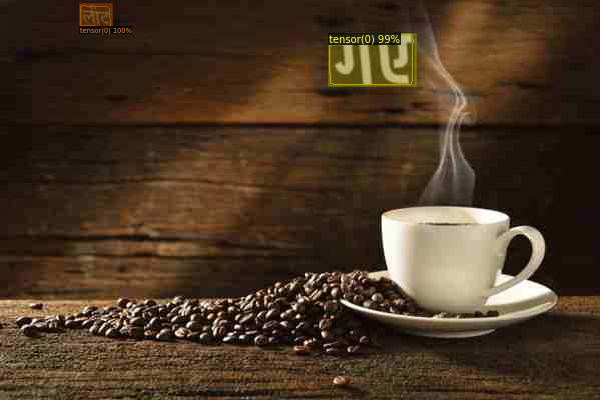

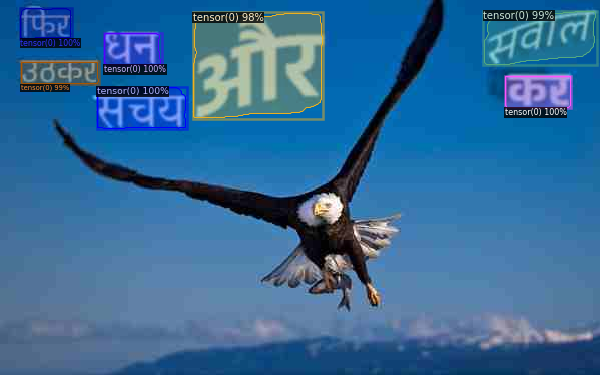

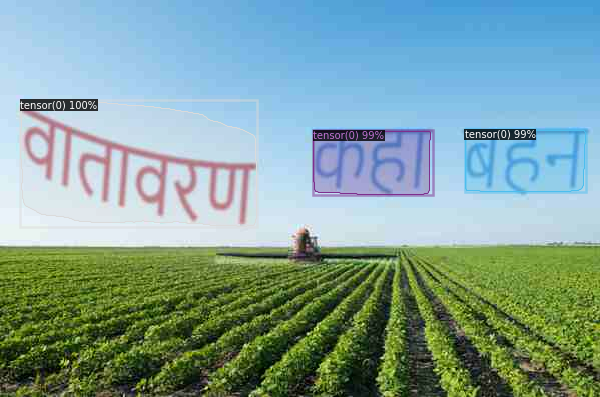

predBox_dims ---->   {'/gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images/3548.jpg': [[11.186205863952637, 175.2101593017578, 175.2101593017578, 11.186205863952637, 10.49257755279541, 10.49257755279541, 54.06877517700195, 54.06877517700195], [300.8085632324219, 425.21978759765625, 425.21978759765625, 300.8085632324219, 28.425777435302734, 28.425777435302734, 76.18428802490234, 76.18428802490234], [454.37860107421875, 526.1710815429688, 526.1710815429688, 454.37860107421875, 33.86711883544922, 33.86711883544922, 84.00060272216797, 84.00060272216797], [181.6981964111328, 255.21337890625, 255.21337890625, 181.6981964111328, 6.539124965667725, 6.539124965667725, 77.83626556396484, 77.83626556396484], [449.8235778808594, 488.6755065917969, 488.6755065917969, 449.8235778808594, 202.4373321533203, 202.4373321533203, 238.98361206054688, 238.98361206054688], [421.91632080078125, 472.2648620605469, 472.2648620605469, 421.91632080078125, 161.3211669921875, 161.3211669921875, 207.28089

In [10]:
from detectron2.utils.visualizer import ColorMode
def _get_all_box_coords(x1,y1,x3,y3):
    x2 = x3
    x4 = x1
    y2 = y1
    y4=y3
    return [x1,x2,x3,x4,y1,y2,y3,y4]


def _infer_obj_detection(image_dir,image,predictor):   
  full_path = os.path.join(image_dir,image)
  inputs = cv2.imread(full_path)
  outputs = predictor(inputs)
  v = Visualizer(inputs[:, :, ::-1],metadata=None,scale=1,instance_mode=ColorMode.IMAGE_BW )  # remove the colors of unsegmented pixels. This option is only available for segmentation models
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  return outputs["instances"]._fields["pred_boxes"].tensor.tolist()

imgDir = '/gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images'
infoDict = {}
for eImg in os.listdir(imgDir):
  predBox_dims = _infer_obj_detection(imgDir,eImg,predictor)
  for eBox_info in predBox_dims:
    x1,y1,x3,y3 = eBox_info
    allboxInfo = _get_all_box_coords(x1,y1,x3,y3)
    infoDict.setdefault(os.path.join(imgDir,eImg),[]).append(allboxInfo)

print("predBox_dims ---->  ",infoDict)
annotFolder = '/gdrive/My Drive/Capstone_project_data/Demo Folder'
json_file = "box_annot.json"
with open(os.path.join(annotFolder,json_file),'w') as fh:
  json.dump(infoDict,fh)
fh.close()

In [7]:
def _removeFiles_in_dir(directory):
  dirList = os.listdir(directory)
  if dirList!=[]:
    for efileName in dirList:
      if os.path.isdir(os.path.join(directory,efileName)):
        dirPath = os.path.join(directory,efileName)
        [os.remove(os.path.join(dirPath,efileName)) for efileName in os.listdir(dirPath)]
        os.rmdir(dirPath)
      else:
        os.remove(os.path.join(directory,efileName))

In [8]:
def _trim_validation_images(img_dir,infoDict,cropped_imgs_dir):
  for e_image,boxList in infoDict.items():
    file_name = str(e_image.split('/')[-1].split('.')[0])
    try:
      os.mkdir(os.path.join(cropped_imgs_dir,str(file_name)))
    except:
      _removeFiles_in_dir(os.path.join(cropped_imgs_dir,str(file_name)))
    for ind,posList in enumerate(boxList):
        px = posList[0:4]
        py = posList[4:8]
        im = Image.open(e_image)
        crop_image = im.crop((px[0]+.75,py[0]+.75,px[2]+.75,py[2]+.75))
        data = np.asarray(crop_image)
        resize_img = cv2.resize(data,(128,128),fx=1,fy=2,interpolation=cv2.INTER_CUBIC)
        data = np.asarray(resize_img)
        _filter_bacground(data)
        new_img_path = os.path.join(cropped_imgs_dir,str(file_name),str(ind)+".jpg")
        new_img_path = r'{}'.format(new_img_path)
        cv2.imwrite(new_img_path,data)

def _filter_bacground(img):
    #img = cv2.imread(img)
    gray  = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU|cv2.THRESH_BINARY)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    opening  = cv2.morphologyEx(thresh,cv2.MORPH_DILATE,kernel,iterations=3)
    opening  = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=3)

    result =cv2.GaussianBlur(opening,(1,1),0)
    result  = cv2.morphologyEx(result,cv2.MORPH_DILATE,kernel,iterations=3)
    cv2.cvtColor(result,cv2.COLOR_GRAY2RGB)
    cv2.addWeighted(result, 50., result, 0, 50.)

In [5]:
%cd '/gdrive/My Drive/Capstone_project_data/Demo Folder'
!ls

/gdrive/My Drive/Capstone_project_data/Demo Folder
 box_annot.json   cropped_images  'Demo Images'   Img_Text_Recognition.pt


In [ ]:
parent_path = r'/gdrive/My Drive/Capstone_project_data/Demo Folder'
crop_Directory = os.path.join(parent_path,"cropped_images")
try:
  os.mkdir(crop_Directory)
except FileExistsError:
  _removeFiles_in_dir(crop_Directory)

predFile = os.path.join(parent_path,json_file)
with open(predFile,'r') as fh:
  infoDict = json.load(fh)
print("loaded json")
_trim_validation_images(imgDir,infoDict,crop_Directory)

**Image To text Model**

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import random
import numpy as np
import time
import pandas as pd
from torchvision import transforms
from collections import OrderedDict
from skimage import io
import matplotlib

In [13]:
class RCNN(nn.Module):
  def __init__(self,imgChannel,imgHeight,imgWidth,output_size,mapHidden=64,rnn_hidden =256,leaky_relu=False,verbose=False):
    super().__init__()
    self.verbose = verbose
    self.encoder,(n_channels,height,width) = self._cnn_backbone(imgChannel,imgHeight,imgWidth,leaky_relu)
    self.map_to_seq = nn.Linear(n_channels*height,mapHidden) ## mapHidden > len(hindivocab)
    self.rnn1 = nn.LSTM(mapHidden,rnn_hidden)
    self.dense = nn.Linear(rnn_hidden,output_size)
    self.softMAX = nn.Softmax(dim = 2)
    self.verbose = verbose
    
  def _cnn_backbone(self,img_channel,img_height,img_width,leaky_relu):
    self.encoder = nn.Sequential()
    assert img_height % 16 == 0
    assert img_width % 4 == 0

    channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
    kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
    strides = [1, 1, 1, 1, 1, 1, 1]
    paddings = [1, 1, 1, 1, 1, 1, 0]

    cnn = nn.Sequential()
    def conv_relu(i, batch_norm=False):
      # shape of input: (batch, input_channel, height, width)
      input_channel = channels[i]
      output_channel = channels[i+1]

      cnn.add_module(
          f'conv{i}',
          nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i])
      )

      if batch_norm:
          cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

      relu = nn.LeakyReLU(0.2, inplace=True) if leaky_relu else nn.ReLU(inplace=True)
      cnn.add_module(f'relu{i}', relu)
    
    conv_relu(0)
    cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2))
    # (64, img_height // 2, img_width // 2)

    conv_relu(1)
    cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
    # (128, img_height // 4, img_width // 4)

    conv_relu(2)
    conv_relu(3)
    cnn.add_module(
        'pooling2',
        nn.MaxPool2d(kernel_size=(2, 1))
    )  # (256, img_height // 8, img_width // 4)

    conv_relu(4, batch_norm=True)
    conv_relu(5, batch_norm=True)
    cnn.add_module(
        'pooling3',
        nn.MaxPool2d(kernel_size=(2, 1))
    )  # (512, img_height // 16, img_width // 4)

    conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)

    output_channel, output_height,output_width = \
        channels[-1], img_height // 16 - 1, img_width // 4 - 1
    return cnn, (output_channel, output_height,output_width)

  def forward(self,x,train=True):
    conv = self.encoder(x)
    if self.verbose:
      print("Input Shape : ",x.size())
      print("Encoder Output : ",conv.size())

    batch, channel, height, width = conv.size()
    conv = conv.view(batch, channel * height, width)
    conv = conv.permute(2, 0, 1)  # (width, batch, feature)
    seq = self.map_to_seq(conv)
    recurrent, _ = self.rnn1(seq)
    output = self.dense(recurrent)
    if not train:
      output = self.softMAX(output)
    if self.verbose:
      print("Input to Decoder : ",seq.size())
      print("RNN Output : ",recurrent.size())
      print("Decoder Ouptput : ",output.size())

    return output

In [14]:
%cd /gdrive/My Drive/Capstone_project_data/ImgtoText/Cropped_Images/cropped_data
!ls

/gdrive/My Drive/Capstone_project_data/ImgtoText/Cropped_Images/cropped_data
annotations.txt  Img_Text_Recognition.pt    readme.txt
cropped_dir	 model_Text_Recognition.pt


**Loading the pre Trained weights for Trained Image -> Text Model**

In [15]:
net = RCNN(3,128,128,130,verbose=False)
checkpoint = torch.load('Img_Text_Recognition.pt',map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

In [16]:

def _return_collapsedIndexes(idxList):
  idxList = idxList.squeeze(1).int().tolist()
  cleanedList = []
  for ind,wordInd in enumerate(idxList):
    if ind==0:
      cleanedList.append(wordInd)
      continue
    if cleanedList[-1] ==wordInd:continue
    else:cleanedList.append(wordInd)
  return cleanedList

def _convertSource_toList(source):
  source = source.detach()
  source_idx = torch.argmax(source,dim=2)
  collapsedIndexs = _return_collapsedIndexes(source_idx)
  return collapsedIndexs
  
def _convertIndex_toString(indexx):
  def _get_vocabList():
    blank,padChar = '-','<PAD>'
    all_hindi_alpha = [blank,padChar]+[chr(i) for i in range(2304,2432)]
    all_hindi_alpha = {all_hindi_alpha[i]:i for i in range(len(all_hindi_alpha))} 
    return all_hindi_alpha
  
  VocabList = _get_vocabList()
  k,v = list(VocabList.keys()),list(VocabList.values())
  ss = ''
  for i in indexx:
    if i == 0:
      continue
    ss+=k[v.index(i)]
  return ss




In [17]:
%cd '/gdrive/My Drive/Capstone_project_data/Demo Folder/cropped_images'
!ls

/gdrive/My Drive/Capstone_project_data/Demo Folder/cropped_images
1514  3067  3548  3574	4350


In [18]:
def _get_image_tensor(image_path):
  def _transform_image(imgTensor):
    transform_batch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    imgTensor = transform_batch(imgTensor)
    return imgTensor
  img_tensor = io.imread(image_path)
  img_tensor = _transform_image(img_tensor)
  img_tensor = transforms.functional.resize(img_tensor,(128,128)) 
  return img_tensor.unsqueeze(0)


**Run Inference on trained model**

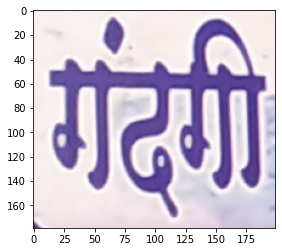

***************Predicted Hindi Word ---->गंदगी***************


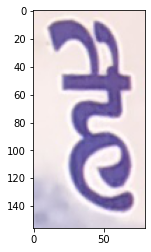

***************Predicted Hindi Word ---->है***************


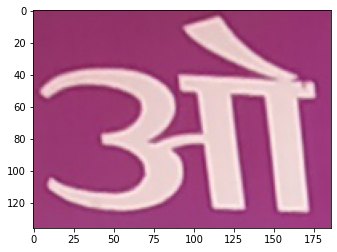

***************Predicted Hindi Word ---->ओ***************


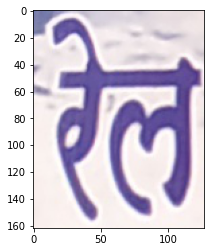

***************Predicted Hindi Word ---->रेल***************


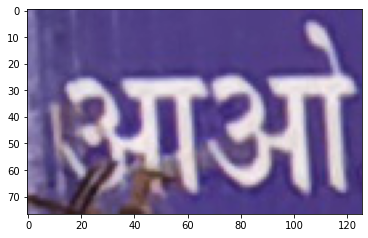

***************Predicted Hindi Word ---->आओ***************


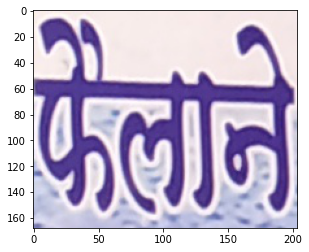

***************Predicted Hindi Word ---->फैलने***************


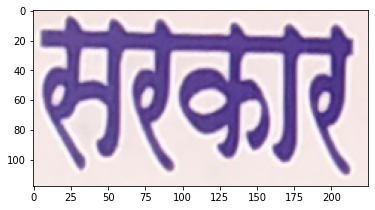

***************Predicted Hindi Word ---->सरकार***************


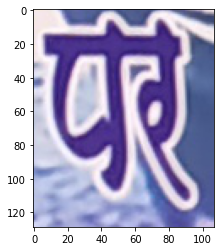

***************Predicted Hindi Word ---->पर***************


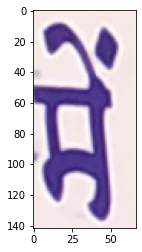

***************Predicted Hindi Word ---->में***************


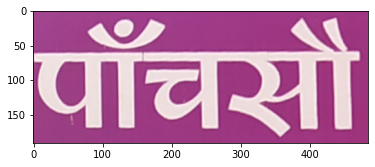

***************Predicted Hindi Word ---->पाँचसौ***************


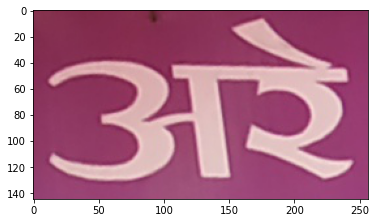

***************Predicted Hindi Word ---->अरे***************


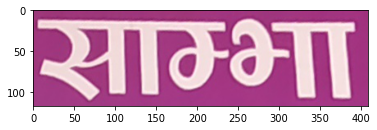

***************Predicted Hindi Word ---->सम्भा***************


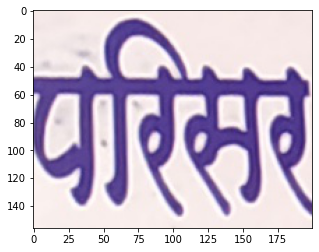

***************Predicted Hindi Word ---->परिसर***************


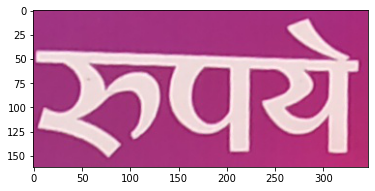

***************Predicted Hindi Word ---->रुपये***************


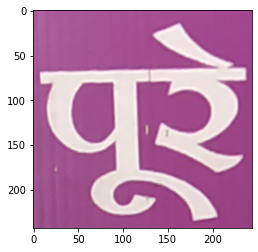

***************Predicted Hindi Word ---->पूरे***************


In [19]:
from IPython.display import clear_output
import time
trimmedImages_path = "/gdrive/My Drive/Capstone_project_data/Demo Folder/cropped_images"
randDirectory = random.sample(os.listdir(trimmedImages_path),1)[0]
files = os.listdir(os.path.join(trimmedImages_path,randDirectory))
counter=0
all_pred_words = []
for eimage in files:
  imgtensor = _get_image_tensor(os.path.join(trimmedImages_path,randDirectory,eimage))
  predtensor = net(imgtensor,train=False)
  sourceList = list(_convertSource_toList(predtensor))
  pred_hindiWord = _convertIndex_toString(sourceList)
  all_pred_words.append(pred_hindiWord)
  img_array = io.imread(os.path.join(trimmedImages_path,randDirectory,eimage))
  
  plt.imshow(img_array)
  plt.show()
  print("*"*15+"Predicted Hindi Word ---->"+pred_hindiWord+"*"*15)
  


**Machine Transliteration Hindi -> English**

In [20]:
def test(net,hWord,tar_len=30,device='cpu'):
  def word_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index["PAD"]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

  pad = "PAD"
  hindi_alphabets = [pad]+[chr(alpha) for alpha in range(2304, 2432)]
  hindi_alphabets_indexed = {hindi_alphabets[i]:i for i in range(len(hindi_alphabets))}

  english_alphabets = string.ascii_uppercase
  english_alphabets_indexed = {}
  english_alphabets_indexed[pad]=0
  for ind,char in enumerate(english_alphabets,start=1):
    english_alphabets_indexed[char] = ind


  data = word_rep(hWord,hindi_alphabets_indexed)
  key,val = list(english_alphabets_indexed.keys()),english_alphabets_indexed.values()
  net.eval().to(device)
  outputs = net(data,trainFlag=False)
  convertedList = [[] for i in range(outputs[0].size()[0])]
  for eTensor in outputs:
    indexes = torch.argmax(eTensor,dim=1).tolist()
    strr = ''
    for i,index in enumerate(indexes):
      strr = key[index]
      convertedList[i].append(strr)
  
  for eList in convertedList:
    cleaned_str = ''
    for eChar in eList:
      if eChar!='PAD':cleaned_str+=eChar
  return cleaned_str

In [21]:
class Encoder_Decoder_with_Attention(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,device='cpu',verbose=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.encoder = nn.GRU(input_size,hidden_size)
    self.decoder = nn.GRU(hidden_size*2,hidden_size)

    self.h2o = nn.Linear(hidden_size,output_size)    
    self.softMAX = nn.LogSoftmax(dim=2)
    self.Fll = nn.Softmax(dim=2)
    self.TaNh = nn.Tanh()

    self.W = nn.Linear(self.hidden_size,self.hidden_size)
    self.U = nn.Linear(self.hidden_size,self.hidden_size)
    self.attn = nn.Linear(self.hidden_size,1)

    self.outTohidden = nn.Linear(self.output_size,self.hidden_size)
    self.verbose = verbose

  def forward(self,input,targetLen=30,GT=None,trainFlag=True,device='cpu'):
    encoder_output,lastHidden = self.encoder(input)
    encoder_output = encoder_output.permute(1,0,2)
    if self.verbose:
      print("Endcoder Input : ",input.size())
      print('Encoder all time step hidden states : ',encoder_output.size())
      print('Encoder Last hidden States : ',lastHidden.size())
    decoderState = lastHidden
    decoderInput = torch.zeros(1,1,self.output_size).to(device)

    U = self.U(encoder_output) ## (no.of time steps,bathc Size,hidden size)
    outputlist = []
    for i in range(targetLen):
      
      W = self.W(decoderState).repeat(1,1*U.size()[1],1) ## (no.of time steps,batch Size,hidden size)
      attn = self.attn(self.TaNh(U+W)).permute(0,2,1) ## (1,1,no.of time steps)
      attn_applied = torch.bmm(attn,encoder_output) ## (1,1,hidden size)

      embedding = self.outTohidden(decoderInput) ## (1,1,hidden size)
      out,decoderState = self.decoder(torch.cat([embedding,attn_applied],dim=2))
      output = self.softMAX(self.h2o(decoderState))

      if self.verbose:
        print("U*Encoder all Time step hidden states : ",U.size())
        print("W*Decoder Previous hidden state : ",W.size())
        print("attn Fynction output : ",attn.size())
        print('Attention Applied : ',attn_applied.size())
        print("Previous Character Embedding : ",embedding.size())
        print("Intermediate Decoder Output : ",out.size())
        print("Decoder final Output : ",output.size())

      if trainFlag:
        outputlist.append(output.view(1, -1))
      else:
        output_eval = self.Fll(self.h2o(out))
        outputlist.append(output_eval.squeeze(0))
        
      maxIndexes = torch.argmax(output,dim=2,keepdim=True).type(torch.int64)
      if GT!=None:
        maxIndexes = GT[i].reshape(1, 1, 1)

      one_hot = torch.FloatTensor(output.size()).to(device)
      one_hot.zero_()
      one_hot.scatter_(2,maxIndexes,1)
      decoderInput = one_hot.detach()

    return outputlist



In [22]:
%cd '/gdrive/My Drive/Capstone_project_data/Without_Attention_state_dict_loss~1.6'
!ls

/gdrive/My Drive/Capstone_project_data/Without_Attention_state_dict_loss~1.6
model_attention.pt  model.pt


In [23]:
modAttentionObj = Encoder_Decoder_with_Attention(129,256,27,device='cpu',verbose=False)
modAttentionObj.load_state_dict(torch.load('model_attention.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [26]:
print("Words Translitrated from Hindi -> English")
print('\n'*5)
for ehindiWord in all_pred_words:
  englishWord = test(modAttentionObj,ehindiWord)
  print(ehindiWord+"   Transliterated to ---->     "+englishWord)
  

Words Translitrated from Hindi -> English






गंदगी   Transliterated to ---->     GANDAGI
है   Transliterated to ---->     HAI
ओ   Transliterated to ---->     O
रेल   Transliterated to ---->     RAIL
आओ   Transliterated to ---->     AA
फैलने   Transliterated to ---->     FALLEE
सरकार   Transliterated to ---->     SARKAR
पर   Transliterated to ---->     PAR
में   Transliterated to ---->     MEIN
पाँचसौ   Transliterated to ---->     PANCCAU
अरे   Transliterated to ---->     ARE
सम्भा   Transliterated to ---->     SAMBHA
परिसर   Transliterated to ---->     PARISER
रुपये   Transliterated to ---->     RUPAYE
पूरे   Transliterated to ---->     PURR
